# RK(3,2)-FB on 1D SWEs

Consider a simple model problem:
\begin{align*}
    \frac{\partial \eta}{\partial t} &= -c \frac{\partial u}{\partial x}, \\
    \frac{\partial u}{\partial t} &= -c \frac{\partial \eta}{\partial x}.
\end{align*}
Note that these are 1D linearized SWEs.

With the goal of applying a von Neumann stability anaysis, we can apply a Fourier transform in $x$ to the above to get
\begin{align*}
    \frac{\partial \hat{\eta}}{\partial t} &= -ick \hat{u}, \\
    \frac{\partial \hat{u}}{\partial t} &= -ick \hat{\eta},
\end{align*}
From now on, write $u = \hat{u}$ and $\zeta = \hat{\zeta}$ to ease notation.

Chose a time-step $\Delta t$ and let $\tilde{K} = k\Delta x$ and $\nu = c\frac{\Delta t}{\Delta x}$. The RK(3,2)-FB algorithm for this system is then given by:
\begin{align*}
    \bar{\eta}^{n+1/3} &= \zeta^n - \frac{i \nu\tilde{K}}{3} u^n \\
    \bar{u}^{n+1/3} &= u^n - \frac{i \nu\tilde{K}}{3} \left( \beta_1\bar{\eta}^{n+1/3} + (1 - \beta_1)\eta^n \right) \\
    & \\
    \bar{\eta}^{n+1/2} &= \zeta^n - \frac{i \nu\tilde{K}}{2} \bar{u}^{n+1/3} \\
    \bar{u}^{n+1/2} &= u^n - \frac{i \nu\tilde{K}}{2} \left( \beta_2 \bar{\eta}^{n+1/2} + (1 - \beta_2)\eta^n \right), \\
    & \\
    \zeta^{n+1} &= \zeta^n - i \nu\tilde{K} \bar{u}^{n+1/2} \\
    u^{n+1} &= u^n -i \nu\tilde{K} \left( \beta_3\eta^{n+1} + (1-2\beta_3)\bar{\eta}^{n+1/2} + \beta_3\eta^n \right)
\end{align*}
where $\beta_i$ for $i = 1, 2, 3$, are the FB-weights.

In [1]:
from sympy import *
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# define relevent symbols 
#     _u = u^n, _zeta = \zeta^n
#     U1 = \bar{u}^{n+1/3}, ZETA1= \bar{\zeta}^{n+1/3}
#     U2 = \bar{u}^{n+1/2}, ZETA2= \bar{\zeta}^{n+1/2}
#     u = u^{n+1}, zeta = \zeta^{n+1}
_u, _eta = symbols('u^n \zeta^n')
lam, nu, Ktilde, beta1, beta2, beta3 = symbols('lambda nu K beta_1 beta_2 beta_3')

# define time-stepping scheme
ETA1 = _eta - (I*nu*Ktilde/3) * _u
U1 = _u - (I*nu*Ktilde/3) * ( beta1*ETA1 + (1-beta1)*_eta )

ETA2 = _eta - (I*nu*Ktilde/2) * U1 
U2 = _u - (I*nu*Ktilde/2) * ( beta2*ETA2 + (1-beta2)*_eta )

eta = _eta - I*nu*Ktilde*U2
u = _u - I*nu*Ktilde * ( beta3*eta + (1-2*beta3)*ETA2 + beta3*_eta )

Now, we have a system of linear equations in $\eta^n$ and $u^n$. We can find the amplification matrix for the scheme by writing it in the form
$$ \mathbf{w}^{n+1} = G \mathbf{w}^n, $$
where $G$ is the amplification matrix and $\mathbf{w}^* = (\eta^*, u^*)^T$.

We care about the amplification matrix $G$ as it follows from the above that $\mathbf{w}^n = G^n \mathbf{w}^0$. In turn, it follows that the solution $\mathbf{w}^n$ is bounded as $n \to \infty$ if and only if $||G^n||$ is bounded as $n \to \infty$.

In [2]:
# create the amplification matrix G
_w = [_eta, _u]
w = [eta, u]
_G, _ = linear_eq_to_matrix(w, _w)

x = [nu, beta1, beta2, beta3, Ktilde]
_calcG = lambdify(x, _G)

Observe that we can write the original, Fourier transformed, system as
$$ \frac{\partial}{\partial t}\begin{pmatrix} \eta \\ u \end{pmatrix} = \begin{pmatrix} 0 & -ick \\ -ick & 0 \end{pmatrix} \begin{pmatrix} \eta \\ u \end{pmatrix}. $$

One can show that the general solution to the system is
$$ \begin{pmatrix} \eta(t) \\ u(t) \end{pmatrix} = e^{t \begin{pmatrix} 0 & -ick \\ -ick & 0 \end{pmatrix}} \begin{pmatrix} \zeta(0) \\ u(0) \end{pmatrix}, $$
and that eigenvalues of the matrix exponential above are
$$ \lambda = e^{\pm ick t}. $$
At time $t = \Delta t$, these eigenvalues are $e^{\pm\nu\tilde{K}}$.

In [3]:
def swapRealImag(x):
    return x.imag + 1.j*x.real

# Define a function to create a plot comparing exact/numerical eigenvalues
def eigValPlot(G, KtildeVal, a=-np.pi, b=np.pi, delta=np.pi/512, nuDotLimit=np.pi/3):
    
    red = '#ee4035'
    orange = '#f37736'
    yellow = '#fdf498'
    green = '#7bc043'
    blue = '#0392cf'
    
    fig, ax = plt.subplots(1)

    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')

    axLim = 1.5
    ax.set_xlim(-axLim, axLim)
    ax.set_ylim(-axLim, axLim)
    ax.set_aspect(1)

    unitCircle = plt.Circle((0, 0), 1, fill=False, color=orange)
    ax.add_artist(unitCircle)

    approx_real = []
    approx_imag = []

    for l in np.arange(-32, 32, 1e-2):
        nu = l*np.pi/16
        # get complex values for exact and approx eigen values
        GEigVals = swapRealImag( np.sort( swapRealImag( sp.linalg.eigvals(G(nu)) ) ) )
        approx = GEigVals[1 if nu >= 0 else 0]
        
        approx_real.append( approx.real )
        approx_imag.append( approx.imag )
        
        absValApprox = np.sqrt(approx.real**2 + approx.imag**2)
        
        if np.abs(nu) <= nuDotLimit and \
            ( np.isclose(l%1, 1, atol=1e-4) or 
              np.isclose(l%1, 0, atol=1e-4) ):
            exact = np.exp(1.j*nu*KtildeVal)
            
            # plot exact and approx eigen values
            colo = blue if absValApprox <= 1 else red
            ax.scatter(exact.real, exact.imag, marker='o', color=orange)
            ax.scatter(approx.real, approx.imag, marker='*', color=colo)
            # connect exact to approx with dashed line
            reals = [approx.real, exact.real]
            imags = [approx.imag, exact.imag]
            ax.plot(reals, imags, color='black', linestyle='dashed', linewidth=0.75, alpha=0.5)
        # END if
    # END for

    ax.plot(approx_real, approx_imag, color=blue)
# END eigValPlot()

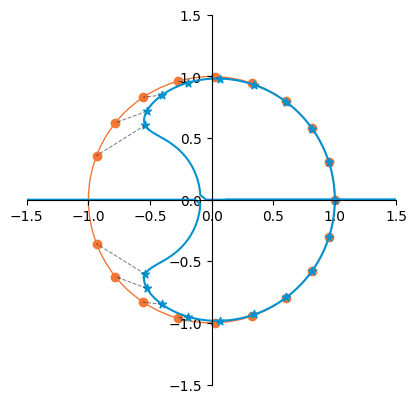

In [10]:
betas = {'U0C1': [0.500, 0.500, 0.344],
         'U0C2': [0.516, 0.532, 0.331],
         'U.05C1': [0.531, 0.531, 0.313],
         'U.15C1': [0.359, 0.578, 0.234],
         'U.25C1': [0.656, 0.938, 0.188]}

KtildeVal = np.pi/2
vals = betas['U.05C1']
optG = lambda nu: _calcG(nu, vals[0], vals[1], vals[2], KtildeVal)

eigValPlot(optG, KtildeVal, delta=np.pi/512, nuDotLimit=np.pi/1.75)